# Demo of Self Attention in Pytorch 

In this Notebook we want to test, that Self-Attention and Piece wise Feed Forward Neural Networks can solve a simple logical, deterministic problem. Furthermore, we want to attest to the degree, that the attention weights can "explain" the predictions. We see that this is the case for Piece Wise Feed Forward Neural Netowrks but it is not! the case for Self Attention Neural Networks. We conjegture, that this is due to the fact that the representation of Self Attention is dependend on all elements of the input sequence

In [1]:
import random
import numpy as np
from model_pytorch import *
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,sampler,DataLoader

import torch
import torch.nn as nn
from tensorboardX import SummaryWriter
from sklearn.metrics import roc_auc_score


In [2]:
random.seed(123)
batch_size=1024
max_epochs=500

# More complex generation

In [3]:
#then we set up a logical function 
def add_1(a,b,v,rand_list):
    #If i do it this way the ordereing doenst matter !!!! ( have to modify it)
    places_a=np.sum(rand_list[:,0:2]==a,axis=1)==2
    places_b=np.sum(rand_list[:,0:2]==b,axis=1)==2
    #not using the value right now
    
    if (any(places_a) and any(places_b)): 
        #and any(rand_list[places_a][:,2]>v) and any(rand_list[places_b][:,2]>v)):
        return True
    else:
        return False

In [4]:
class dummy_data(Dataset):
    def __init__(self, input,output,reason):     
        
        self.data=input
        self.label=output
        self.reason=reason
        
    def __len__(self):
        return int(len(self.data))
    
    def __getitem__(self, index):
        
        X=self.data[index]
        y=self.label[index]
        r=self.reason[index]
        return X, y, r

In [5]:
#THe collate difnes how data gets batched 
#here we are using a simple dynamic badding for batching. 
def my_collate(batch):
    texts=([x[0] for x in batch])
    labels=np.array(([x[1] for x in batch]))
    reason=np.array(([x[2] for x in batch]))
    batch_size=len(batch)
    maxlen=np.max([len(x) for x in texts])
    text_stack=np.zeros(shape=(batch_size,maxlen,3))
    for enu,txt in enumerate(texts):
        text_stack[enu,0:len(txt),:]=txt

    return torch.tensor(text_stack[:,:,0]).cuda(),torch.tensor(text_stack[:,:,1]).cuda(),torch.tensor(text_stack[:,:,2]).cuda(),torch.tensor(labels).cuda(),reason



In [6]:
class simple_fraud_model(nn.Module):
    def __init__(self, d_model=32,heads=1,nlay=1,dropout=0,SelfA=True,return_w=False):
        
        super(simple_fraud_model,self).__init__()
        self.return_w=return_w
        emb_d_1=int(d_model/2)
        emb_d_2=int(d_model/2)
        
        self.embedding_1=nn.Embedding(num_embeddings=21,embedding_dim=emb_d_1)
        self.embedding_2=nn.Embedding(num_embeddings=21,embedding_dim=emb_d_2)
        self.initial_linear=nn.Linear(d_model,d_model)
        
        if SelfA==True:
            self.encoder_layers=EncoderLayer(d_model=d_model,heads=heads,dropout=dropout,share_params=True)

        if SelfA==False:
            self.encoder_layers=FeedForward(d_model)


        self.mula=multi_attention(input_dim=d_model,key_dim=d_model,nheads=1,return_weights=True,value_dim=d_model)

        self.fully_con=nn.Linear(d_model,d_model*4)
        self.relu=nn.ReLU()
        
        self.fully_con_1=nn.Linear(d_model*4,d_model*4)
        self.relu_1=nn.ReLU()
        
        
        self.final_fully_con=nn.Linear(d_model*4,1)
        self.sig=nn.Sigmoid()
        self.selfa=SelfA
        self.norm=nn.BatchNorm1d(d_model)
        
    def forward(self, x1,x2,x3,return_w):
        e1=self.embedding_1(x1)
        e2=self.embedding_2(x2)

        cat=torch.cat([e1,e2],dim=2)
        cat=self.relu(self.initial_linear(cat))
        if self.selfa==True:
            
            feat,w2=self.encoder_layers(cat)
        else:
            feat=self.encoder_layers(cat)

        ag,weights=self.mula(feat)
        ag=self.norm(ag)
        #first layer with a relu activation
        fc=self.relu(self.fully_con(ag.squeeze()))
        #second layer
        fc=self.relu_1(self.fully_con_1(fc))
        #finally the last layer with a sigmoid
        preds=self.sig(self.final_fully_con(fc))
        
        if return_w==False:
            return preds.squeeze()
        if return_w==True:
            
            if self.selfa==True:
                #this might not be a 100% correct
                #We are multiplying the first layer attention weights together with the aggregation weights.
                w=torch.einsum('bkj,bji->bki',weights.permute(0,2,1),w2.squeeze())
                return preds.squeeze(),w#,weights,w2
            else:
                return preds.squeeze(),weights

In [7]:
def explanation_score(sf,it):
    reason_list=[]
    explanation_list=[]
    weight_list=[]
    sf.eval()
    
    for batch in it:

        #We get both inputs
        i1=batch[0].long()
        i2=batch[1].long()
        i3=batch[2].float()

        #this is directly a list 
        r=batch[4]

        #We get both prediction and attention weights 
        predictions,weights=sf(i1,i2,batch[2].float(),True)

        #Get the predictions
        preds_np=np.round(predictions.detach().cpu().numpy())
        
        thresh=0.5
        #get the attention weights 
        weights_np=weights.detach().cpu().numpy()
        fraud_elem=np.where(preds_np>0.5)[0]

        #Only if we actually predict something we care about an explanation (we can change that threshhold)
        if fraud_elem.size>0:
            
            i1=i1.detach().cpu().numpy()
            i2=i2.detach().cpu().numpy()
            i3=i3.detach().cpu().numpy()

            #This is the reason
            for fraud_ele in fraud_elem:

                #get the weigths(we round casue we want to look at them later)
                my_weight=np.squeeze(np.round(weights_np[fraud_ele],2))

                #get the element in the input the model put attention on
                atn_elem=np.where(my_weight>thresh)[0]

                #get the actual value so we can check if the actual confidence is a good measure
                atn_value=np.expand_dims(my_weight[np.where(my_weight>thresh)[0]],axis=1)

                #Next we stack up all inputs 
                in_elem=np.stack([np.squeeze(i1[fraud_ele]),np.squeeze(i2[fraud_ele]),np.squeeze(i3[fraud_ele])],axis=1)

                #we get the input elements our model has picked out 
                in_elem_j=in_elem[atn_elem]
            
                #then we concatenate together with the other variables
                in_elem_j=np.concatenate([in_elem_j,atn_value],axis=1)

                #in the end we save everything in a list for evaluation
                explanation_list.append(in_elem_j)
                reason_list.append(r[fraud_ele])
                
                
    if (len(reason_list))>0 and (len(explanation_list))>0:
        error_list=[]
        reason_wrong=[]

        for explanation,reason in zip(explanation_list,reason_list):
            e=explanation
            r=reason
            if len(e)>0:
                splits=np.split(e[:,0:4],axis=0,indices_or_sections=len(e))

                if len(r)>0:
                    e=np.array([j[0][0:2] for j in splits])
                    #new_array = [tuple(row) for row in e]
                    #e = np.unique(new_array)

                    e=np.unique(e,axis=0)

                    r=np.array(r[0][0:2])

                    #if not np.array_equal(np.sort(r.flatten()),np.sort(e.flatten())):
                    error_list.append(splits)
                    reason_wrong.append(r)
                else:
                    error_list.append(splits)
                    reason_wrong.append(r)
            else:
                error_list.append(e)
                reason_wrong.append(r)        
                    #print(reason_wrong)
        #print(reason_list)
        #so we define it as an error if we did not return the exact two conditions that lead to a "fraud" in a particular claim 
        error_score=len(error_list)/len(reason_list)
        
        return error_score,error_list,reason_wrong
    else:
        return 1,[],[]
    

In [8]:
#A train and evaluation funciton
def train_eval(atnm,train,opti,crit,eval_metrics,iterator,n_iter,writer):
    
    '''
    Args:
    atnm: A Model to be trained/evalued
    train: If we want to train/eval (If train we sub the gradient)
    opti: An optimizer to be used
    crit: A loss function to be used
    eval_matrics: If we want to keep track of predictions during batch gen and in the end
    calculate a metric on the whole data (aka the AUC)
    iterator: The data generator as an iterator
    n_iter: the current step to be updated
    writer: the tensorboard writer used to keep trakc of training results
    
    '''
    if train==False:
        loss_val=[]
        name1="val_loss"
        name2="val_roc"  
        atnm.eval()
    else:
        name1="train_loss"
        name2="train_roc"
        atnm.train()

    if eval_metrics:
        store_label=[]
        store_preds=[]
        
    #The epcoh 
    for batch in iterator:
        #print(batch[0].shape[1])
        opti.zero_grad()
        #batch=ba
        predictions,w=atnm(batch[0].long(),batch[1].long(),batch[2].float(),True)        #print(predictions)
        loss = crit(predictions, batch[3].float().cuda())

        if train==True:
            loss.backward()
            opti.step()
            n_iter=n_iter+1
            writer.add_scalar(name1,loss.cpu().detach().numpy(),n_iter)
        #when we dont train we dont write during epoch but only at the end
        #also we dont up the iter
        if train==False:
            loss_val.append(loss.cpu().detach().numpy())
        if eval_metrics== True: 
            store_preds.append(predictions.cpu().detach().numpy())
            store_label.append(batch[3].float().cpu().detach().numpy())
            
        del predictions
        del loss
        
    ### End of Batch
    if train == False:
        writer.add_scalar(name1,np.mean(loss_val),n_iter)

    if eval_metrics== True: 
        store_preds=np.concatenate(store_preds)
        store_label=np.concatenate(store_label)
        roc=roc_auc_score(store_label,store_preds)
        writer.add_scalar(name2,roc,n_iter)
        
        return roc
    

In [9]:
best_lists=[]

In [10]:
best_lists

[]

In [11]:
best_n_list=[]

In [12]:
import pickle

In [36]:
from tqdm import trange

In [37]:
#Here we generate the data we will store:
#first we get a set of fraud elements (a pair of numbers and a numeric value)
for n_fraud in trange(1,20):
    
    for j in range(36):
        fraud_list=[]
        wait=0

        for j in range(n_fraud):
            fraud_elem=[np.array([random.randint(1,20),random.randint(1,20)]),np.array([random.randint(1,20),random.randint(1,20)]),random.random()]
            fraud_list.append(fraud_elem)

        #All the input data present
        all_data=[]
        #if at least one of the "reasons" was present
        all_label=[]
        #and the actual reason present ( we can use that to check if the explanation was correct)
        all_reason=[]

        for j in range(100000):
            rand_list=[]
            for j in range(random.randint(1,100)):
                rand_list.append((random.randint(1,20),random.randint(1,20),random.random()))

            rand_list=np.array(rand_list)

            add_list=[]
            reason_list=[]

            for i in fraud_list:
                if add_1(a=i[0],b=i[1],v=i[2],rand_list=rand_list):

                    add_list.append(True)
                    reason_list.append(i)

                else:
                    add_list.append(False)
            if any(add_list):
                all_label.append(1) 
            else:
                all_label.append(0)

            all_data.append(rand_list)
            all_reason.append(reason_list)
        test_share=0.1
        train_split_elem=int((1-test_share)*len(all_data))

        # we split into train and validation

        train_X=all_data[:train_split_elem]
        val_X=all_data[train_split_elem:]

        train_y=all_label[:train_split_elem]
        val_y=all_label[train_split_elem:]

        train_r=all_reason[:train_split_elem]
        val_r=all_reason[train_split_elem:]

        train_ds=dummy_data(train_X,train_y,train_r)
        val_ds=dummy_data(val_X,val_y,val_r)
        val_dl= DataLoader(dataset=val_ds,
                              batch_size=batch_size,
                              shuffle=False,
                              collate_fn=my_collate
                              )

        train_dl= DataLoader(dataset=train_ds,
                              batch_size=batch_size,
                              shuffle=True,
                              collate_fn=my_collate
                              )


        sf=simple_fraud_model(SelfA=True,d_model=64).cuda()
        criterion=nn.BCELoss()
        optimizer = torch.optim.Adam(sf.parameters(), lr=5e-4)
        scheduler =torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,"max",patience=2,verbose=True)

        writer = SummaryWriter(log_dir="logs2/selfa_{}_{}".format(n_fraud,j))

        sensitivity_list=[]
        totally_correct_list=[]
        auc_list=[]
        lens_list=[]

        for j in range(max_epochs):
            #atnm,train,opti,crit,eval_metrics,iterator
            n_iter=(train_ds.__len__()/batch_size)*j

            roc_t=train_eval(sf,True,optimizer,criterion,True
                           ,iter(train_dl),n_iter=n_iter,writer=writer)

            roc_v=train_eval(atnm=sf
                             ,train=False
                             ,opti=optimizer
                             ,crit=criterion
                             ,eval_metrics=True
                             ,iterator=iter(val_dl)
                            ,writer=writer
                            ,n_iter=n_iter)

            eval_v,error_list,reason_wrong=explanation_score(sf,it=iter(val_dl))

            if len(error_list)>0 and len(reason_wrong)>0:
                #In this list comprehension we check how many of the conditions we recovered (even if we got too many)
                incorrect_predictions=[]
                len_list=[]
                summ=[]
                for err,rea in zip(error_list,reason_wrong):
                    #if its zero, it means either: We have no reason (which adds to the )
                    if len(err)>0 and len(rea)>0:
                        le=np.unique(np.stack([x[0][0:2] for x in err]),axis=0)
                        #here we do the comparrison, if an elemen in the (reason(which is a  tuple) is in the reason list)
                        comp_lists=[m == [x[0][0:2] for x in  err] for m in rea]
                        #if it appears it will show two ones in that row, that means when we sum over the rows we get a 2 
                        #now we have to care about situation, where the releant input appears multiple times. also we need to check thaat
                        #each reason appears, that happens here
                        all_inputs_appear=np.sum([any(np.sum(x,axis=1)==2) for x in comp_lists])==len(comp_lists)
                        summ.append(all_inputs_appear)
                        len_list.append(le)

                    #We didnt put weight on anything (happens at staart of training)
                    if len(err)==0:
                        summ.append(0)
                    if len(rea)==0:
                        incorrect_predictions.append((err,rea))

                sensitivity=np.sum(summ)/len(summ)

            else:
                sensitivity=0

            auc_list.append(roc_v)
            sensitivity_list.append(sensitivity)

            writer.add_scalar("auc",roc_v,n_iter)
            writer.add_scalar("sensitivtiy",sensitivity,n_iter)

            print(roc_v)
            print(sensitivity)
            if len(error_list)>0 and len(reason_wrong)>0:
                lens=np.mean([len(x) for x in len_list])
                print(lens)
                writer.add_scalar("length_ones",lens,n_iter)
                lens_list.append(lens)
                best_len=np.min(lens_list)

            best_auc=np.max(auc_list)
            best_sensi=np.max(sensitivity_list)
            scheduler.step(roc_v)

            if best_auc==1:
                wait=wait+1
                if wait==20:
                    break
            else:

                if roc_v<best_auc:
                    wait=wait+1
                    if wait==20:
                        break
                else:
                    wait=0
                    
        best_lists.append([best_auc,best_sensi,best_len])
        break
        
    best_n_list.append(best_lists)
    break

    with open('result_list_36_20_2_selfa.pickle', 'wb') as handle:
        pickle.dump(best_lists, handle, protocol=pickle.HIGHEST_PROTOCOL)


  0%|          | 0/19 [00:00<?, ?it/s]

0.70210979865332
0
0.997530103704189
0
1.0
0.9935483870967742
2.0
1.0
0.9935483870967742
2.0
1.0
0.9935483870967742
2.0


KeyboardInterrupt: 

In [30]:
np.where(np.array(summ)==0)

(array([ 328, 1376]),)

In [33]:
error_list[1376]

[array([[15.        , 14.        ,  0.80621028,  0.52999997]]),
 array([[ 2.        , 19.        ,  0.40636954,  0.51999998]]),
 array([[ 2.        , 19.        ,  0.3642877 ,  0.51999998]]),
 array([[ 8.        , 19.        ,  0.63543487,  0.50999999]]),
 array([[ 2.        , 19.        ,  0.83050615,  0.51999998]])]

In [35]:
reason_wrong

[array([[17, 20],
        [ 8, 13]]), array([[15, 20],
        [ 6,  5]]), array([[17, 20],
        [ 8, 13]]), array([[ 6, 18],
        [20,  2]]), array([[13,  5],
        [14, 12]]), array([[17, 20],
        [ 8, 13]]), array([[15, 14],
        [19, 14]]), array([[10, 15],
        [ 2, 19]]), array([[13,  5],
        [14, 12]]), array([[10, 15],
        [ 2, 19]]), array([[13,  5],
        [14, 12]]), array([[10, 15],
        [ 2, 19]]), array([[15, 20],
        [ 6,  5]]), array([[14,  3],
        [13,  2]]), array([[10, 15],
        [ 2, 19]]), array([[14,  3],
        [13,  2]]), array([[17, 19],
        [ 8, 19]]), array([[17,  4],
        [15, 18]]), array([[14,  3],
        [13,  2]]), array([[15, 20],
        [ 6,  5]]), array([[13,  5],
        [14, 12]]), array([[17, 20],
        [ 8, 13]]), array([[ 6, 18],
        [20,  2]]), array([[12,  6],
        [ 5,  6]]), array([[15, 20],
        [ 6,  5]]), array([[12,  6],
        [ 5,  6]]), array([[17, 20],
        [ 8, 13]]), 

In [ ]:
ip=torch.tensor(np.array(0.1
                        ))

In [23]:
len(error_list)

1461

In [21]:
reason_wrong[1]

array([[15, 20],
       [ 6,  5]])

In [55]:
def logistic(x,c=1,a=20,b=np.e):
    return c/(1+a*b**(-x))

In [56]:
logistic(ip)

tensor(0.0524, dtype=torch.float64)

In [50]:
Y=[]
for j in np.arange(-10,10,0.1):
    Y.append(logistic(j))

In [52]:
import matplotlib.pyplot as plt


In [53]:
plt.plot(Y)
plt.show()

In [16]:
reason_list=[]
explanation_list=[]
weight_list=[]
sf.eval()

for batch in iter(val_dl):

    #We get both inputs
    i1=batch[0].long()
    i2=batch[1].long()
    i3=batch[2].float()

    #this is directly a list 
    r=batch[4]

    #We get both prediction and attention weights 
    predictions,weights=sf(i1,i2,batch[2].float(),True)
    weight_list.append(weights.detach().cpu().numpy())

In [17]:
weight_list=np.concatenate(weight_list)

In [18]:
weight_list=np.reshape(weight_list,newshape=(weight_list.shape[0]*weight_list.shape[1]*weight_list.shape[2]))

In [19]:
import matplotlib.pyplot as plt

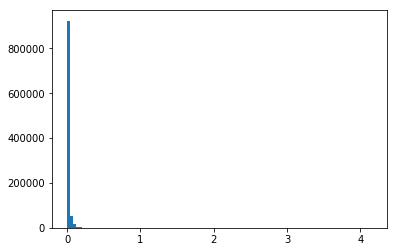

In [20]:
plt.hist(weight_list,bins=100)
plt.show()

In [ ]:
#we can set the threshhold maybe from the distribution


In [14]:
sf=simple_fraud_model(SelfA=True,d_model=32).cuda()
for batch in iter(train_dl):
    #print(batch[0].shape[1])
    #batch=ba
    preds,w,weights,w2=sf(batch[0].long(),batch[1].long(),batch[2].float(),True) 
    break

ValueError: not enough values to unpack (expected 4, got 2)

In [ ]:
splitted_frames=np.array_split(np.array(best_lists),indices_or_sections=9,axis=0)

In [ ]:
with open('result_list.pickle', 'wb') as handle:
    pickle.dump(splitted_frames, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [16]:
error_list

[array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 [array([[2.        , 9.        , 0.60459852, 1.03999996]])],
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float64),
 array([], shape=(0, 4), dtype=float

In [15]:
reason_wrong[1]

[[array([2, 9]), array([ 3, 14]), 0.26655381253138355]]

In [ ]:
my_frame=splitted_frames[0]

In [ ]:
mean_list=[]
mean_best_list=[]
wperfect_list=[]
for my_frame in splitted_frames:
    mean_results=np.nanmean(my_frame,axis=0,)
    where_perfect=np.where(my_frame[:,0]==1)[0]
    mean_perfect=np.nanmean(my_frame[where_perfect],axis=0)
    mean_list.append(mean_results)
    mean_best_list.append(mean_perfect)
    wperfect_list.append(len(where_perfect))

In [ ]:
wperfect_list

In [ ]:
my_frame=splitted_frames[-1]

In [ ]:
mean_results=np.mean(my_frame,axis=0)
where_perfect=np.where(my_frame[:,0]==1)[0]
mean_perfect=np.mean(my_frame[where_perfect],axis=0)

In [ ]:
mean_list

In [ ]:
mean_perfect

In [ ]:
mean_best_list

In [68]:
splitted_frames

[array([[1., 1., 2.],
        [1., 1., 2.],
        [1., 1., 2.],
        [1., 1., 2.],
        [1., 1., 2.],
        [1., 1., 2.],
        [1., 1., 2.],
        [1., 1., 2.],
        [1., 1., 2.],
        [1., 1., 2.]]), array([[1.        , 1.        , 2.20727273],
        [1.        , 1.        , 2.25252525],
        [1.        , 1.        , 2.30944625],
        [1.        , 1.        , 2.28614458],
        [1.        , 1.        , 2.30351438],
        [1.        , 1.        , 2.25631769],
        [1.        , 1.        , 2.31920904],
        [1.        , 1.        , 2.33448276],
        [1.        , 1.        , 2.31692308],
        [1.        , 1.        , 2.17785235]]), array([[0.98873954, 0.98130841, 2.45686901],
        [0.98726427, 0.9880597 , 2.45047923],
        [1.        , 1.        , 2.60373444],
        [1.        , 1.        , 2.55813953],
        [0.98467984, 1.        , 2.50759878],
        [1.        , 1.        , 2.57731959],
        [1.        , 1.        , 2.5979166

In [64]:
mean_perfect

array([1., 1., 2.])